# use all freqband to do binary calssification

In [1]:
import numpy as np
from ecog_band.datasetAllband import SVMDataset
from ecog_band.models import SVMBinClassifier, DecisionTreeBinClassifier, RandomForestBinClassifier, KNeighborsBinClassifier, GaussianNBBinClassifier
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import os
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from ecog_band.utils import *
from ecog_band.solver import Nfold_solver
import pandas as pd
# from ecog_band.datasetExcludeBand import CustomDatasetExcband

/root/pp/covert-reading/Ecog_pretrain/ecog_band/solver.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # may raise warning about Jupyter


In [4]:
HS = 86
freq = 500
elec = 7
path_elec = f'/public/DATA/overt_reading/dataset/HS{HS}/{freq}/{elec}'
y_save_path = f'/root/pp/covert-reading/Ecog_pretrain/binary_classify_results/HS{HS}/{freq}/{elec}'
contribution_save_path = f'/root/pp/covert-reading/Ecog_pretrain/binary_classify_results/HS{HS}/{freq}/{elec}'
band_list = get_all_band()

data_shape: (720, 187875)
x_train shape：(600, 187875), x_test shape：(120, 187875), y_train shape：(600,), y_test shape：(120,)


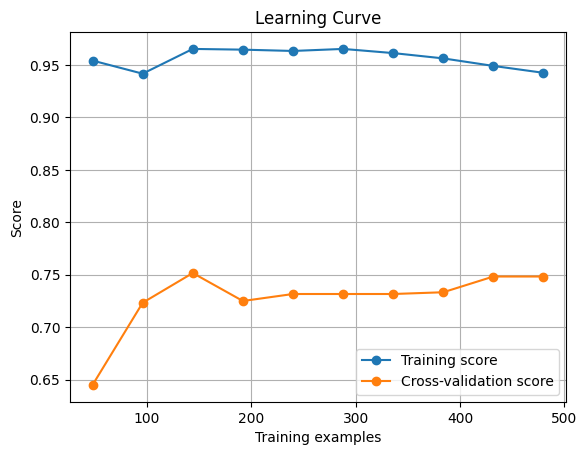

Accuracy on test set: 0.7583333333333333


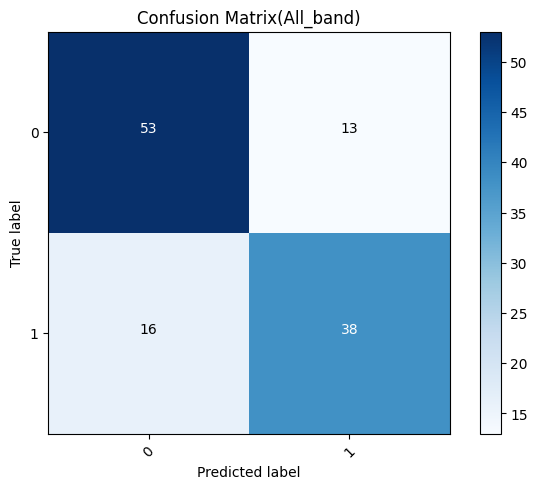

In [2]:
num_samples = len(os.listdir(path_elec))

data_loader = SVMDataset(HS, path_elec, freq, elec, num_samples)
data, labels = data_loader.get_data_labels()
print(f'data_shape: {data.shape}')

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/6, random_state=42)
print(f'x_train shape：{X_train.shape}, x_test shape：{X_test.shape}, y_train shape：{y_train.shape}, y_test shape：{y_test.shape}')# x_train shape：(600, 187875), x_test shape：(120, 187875), y_train shape：(600,), y_test shape：(120,)

# svm = SVMBinClassifier()
svm = DecisionTreeBinClassifier()
svm.train(x_train=X_train, y_train=y_train)

y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
all_band_acc = accuracy_score(y_test, y_pred)

np.save(os.path.join(y_save_path, f'allbands_y_pred.npy'), y_pred)
np.save(os.path.join(y_save_path, f'allbands_y_true.npy'), y_test)

print(f"Accuracy on test set: {all_band_acc}")

# plt confusion matrix
plt_confusion_matric(y_test, y_pred)


data_shape: (720, 187500)


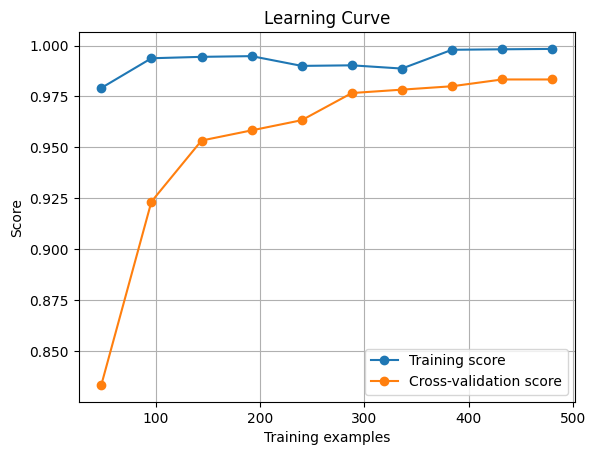

Accuracy on test set without band_else1: 0.9666666666666667


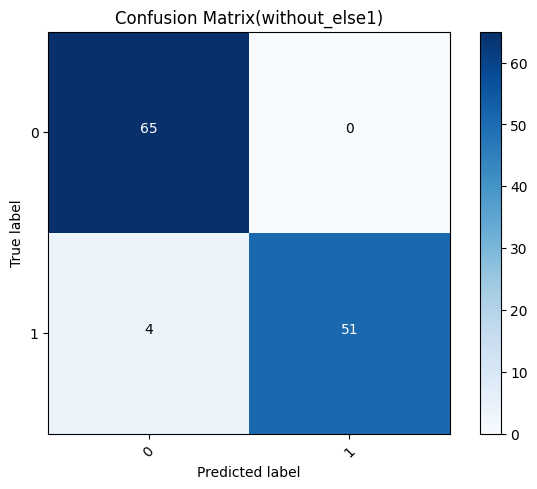

data_shape: (720, 186750)


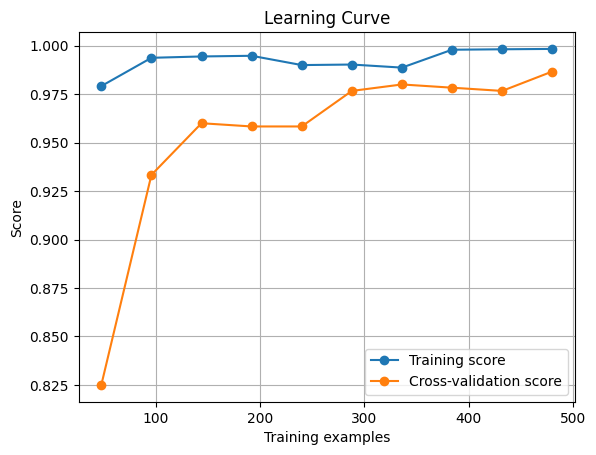

Accuracy on test set without band_delta: 0.95


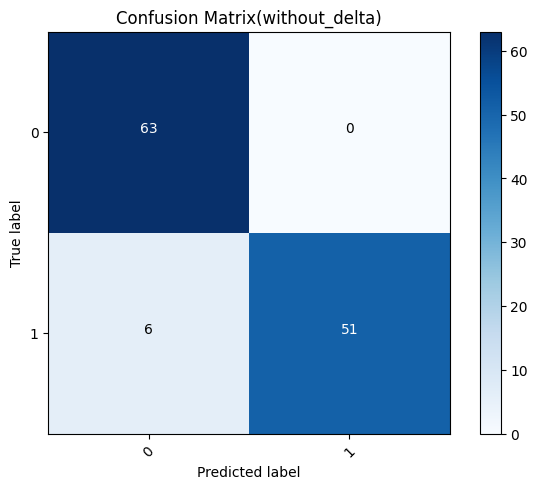

data_shape: (720, 186375)


In [5]:
# classify test on each band
for band in band_list:
    data_loader = SVMDataset(HS, path_elec, freq, elec, num_samples, band)
    data, labels = data_loader.get_data_labels()
    print(f'data_shape: {data.shape}')
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/6, random_state=42)
    svm = DecisionTreeBinClassifier()
    svm.train(x_train=X_train, y_train=y_train)

    y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
    band_acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test set without band_{band}: {band_acc}")

    np.save(os.path.join(y_save_path, f'{band}_y_pred.npy'), y_pred)
    np.save(os.path.join(y_save_path, f'{band}_y_true.npy'), y_test)
    # plt confusion matrix
    plt_confusion_matric(y_test, y_pred, f'without_{band}')


In [ ]:
# show accuracy for each band
accuracy = []
for band in band_list:
    accuracy.append(cal_acc_band1_from_y(y_save_path, band))
pltbar_accuracy(accuracy, band_list)

In [ ]:
data, labels = data_loader.get_data_labels()
print(len(data)) # 6*60*2

In [ ]:
# calculate contribution for each band
baseline_accuracy = cal_acc_band1_from_y(y_save_path, 'allbands')
contributions_list = []

for band in band_list:
    # print(band)
    badn_acc = cal_acc_band1_from_y(y_save_path, band)
    contribution = baseline_accuracy - badn_acc
    print(f'band: {band}, contribution_acc:{contribution}')
    contributions_list.append(contribution)

np.save(os.path.join(contribution_save_path, f'contributions.npy'),contribution_save_path)

In [ ]:
# plt contribution bar
contribution
pltbar_contribution(contribution, band_list)

# permutation test

In [ ]:
data_loader = SVMDataset(HS, path_elec, freq, elec, num_samples)
data, labels = data_loader.get_data_labels()
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/6, random_state=42)
# print(y_train)
np.random.shuffle(y_train)
# print(y_train)
svm = DecisionTreeBinClassifier()

# all bands
svm.train(x_train=X_train, y_train=y_train)
y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
all_bands_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set all_bands: {all_bands_acc}")

contributions = []
accuracy = []
for band in band_list:
    data_loader = SVMDataset(HS, path_elec, freq, elec, num_samples)
    data, labels = data_loader.get_data_labels()
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/6, random_state=42)
    np.random.shuffle(y_train)
    svm.train(x_train=X_train, y_train=y_train)
    y_pred = svm.evaluate(X_test=X_test, y_test=y_test)
    band_acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test set without band_{band}: {band_acc}")
    print(f"contribution on test set for band_{band}: {all_bands_acc-band_acc}")
    contributions.append(all_bands_acc-band_acc)
    accuracy.append(band_acc)

pltbar_accuracy(accuracy, band_list)
pltbar_contribution(contributions, band_list)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.metrics import confusion_matrix
from ecog_band.utils import plt_allband_confusion_matrices

y_true_dict = {}
y_pred_dict = {}

y_save_path = f'/root/pp/covert-reading/Ecog_pretrain/binary_classify_results/HS{HS}/{freq}/{elec}'

confusion_matrices = {}
for band in band_list:
    y_true_dict[band] = np.load(os.path.join(y_save_path, f'{band}_y_true.npy'))
    y_pred_dict[band] = np.load(os.path.join(y_save_path, f'{band}_y_pred.npy'))
    confusion_matrices[band] = confusion_matrix(y_true_dict[band], y_pred_dict[band])

